# Brahms membership sampling experiments

Brahms uses randomness to sample members, it can guarantee that peer's local view will not be poisened if f < 1/3. 
Each node has limited sending rate that can poison the view. 

At any time `t` peer keeps: 
 - $N$ peer for communication 
 - $S$ sample list: might have not defined nodes $\epsilon$

### Requirements

- The overlay constructed out of $N$ should be connected w.h.p 
- The sample after the churn should contain correct nodes and the probablitiy of selecting an honest node is uniform. 

### Components

- Local sampling: choose set $S$ of nodes from the known ids
- Gossip: exchange knowledge with other nodes = dynamic view $V$

Each node has inital $V$ - bootstrap set. $N$ is formed by merging $V$ and $S$.

```

Sample(Element )-> output based on minwise pseudo-random function. Select random value over a stream.

```

Maintain $l_2$ vector of `Sample` blocks, each id stream is an input for each sampler. 
Each sampled id is validated - pinged and reinitialized otherwise.


```
Gossip()
 1. push - send id's to other nodes. Used to reinforce the knowledge of underpresneted nodes(newbies) 
 2. pull - retrive the view from other nodes. Used to spread existing knowledge 
 
```

In a single round: issue $\alpha*l_1$ pushes and $\beta*l_1$ pulls.
If more than some number of pushes is received it will be ignored. 

Pushes must be contrained to portect from the targeted attack, while pulls must be constrained to protect rest. 

### Self healing 

History samples are considered for self-healing purposes. Direct history does not help, as it might be biased too. 

### Parameter analysis 

$l_1$ and $l_2$ = $\Theta(\sqrt[\leftroot{-2}\uproot{2}3]{N})$ is sufficent to gurantee good overlay w.h.p



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import mmh3 # murmurhash: is faster for blooms
import numpy as np
from queue import Queue
import time
import random
import string
import networkx as nx
import itertools

import collections
def construct_graph(G, membership):
    G_p = nx.DiGraph()
    G_p.add_nodes_from(G.nodes())
    for p in G.nodes():
        for p2 in membership[p].get_current_neigh():
            G_p.add_edge(p, p2) 
    return G_p
        

def show_deg_dist(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    plt.figure(1,figsize=(8,8)) 
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()
    

def randomString(stringLength=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

class Sampler:
    
    def __init__(self, nonce):
        self.nonce = nonce
        self._q = None
        self._q_hash = None
    
    def next_val(self, elem):
        el_hash = mmh3.hash128(elem, self.nonce)
        if not self._q or el_hash < self._q_hash:
            self._q = elem
            self._q_hash = el_hash
            
    def sample(self):
        return self._q

    
class BrahmsMembers:
    
    def bootstrap(self, G):
        '''
        Current bootstrap graph         
        '''
        # Inital bootstrap
        # connect to inital number of peers, that are already in the network 
        #choose randomly some nodes in the graph as inital members
        choice_set = list(set(G.nodes()) - {self.id})
        self.V = list(np.random.choice(choice_set, 5, replace=False))
        self.update_sample(self.V)
    
    def get_sample(self):
        return (s.sample() for s in self.S)
    
    def update_sample(self, V):
        for i in V:
            for s in self.S:
                s.next_val(i)
    
    def __init__(self, own_id, l1, l2, a, b, c):
        """
        l1: number of gossip members
        l2: number of samplers
        
        a: push coeficient 
        b: pull coeficient 
        c: history coeficient
        
        """
        assert a+b+c == 1
        self.V = []
        self.S = [Sampler(i) for i in range(1, l2+1)]
        
        self.id = own_id 
        self.v_pull = Queue()
        self.v_push = Queue()
        
        self.l1 = l1
        self.l2 = l2
        self.a = a
        self.b = b
        self.c = c
    
    def get_current_neigh(self):
        return set(self.V) | set(self.get_sample())
    
    def receive_push(self, push):
        self.v_push.put(push)
        
    def receive_pull_req(self, pull):
        self.v_pull.put(list(membership[pull].V))
        
    def run_round(self):
        # Send ping/push request 
        for i in range(int(self.a*self.l1)):
            val1 = np.random.choice(self.V)
            membership[val1].receive_push(val1)
            
        for i in range(int(self.b*self.l2)):
            val1 = np.random.choice(self.V)
            # pull_request to val1
            self.receive_pull_req(val1)
        # wait for some time 
        time.sleep(0.1)
        
        pushes = list(self.v_push.queue)
        rand_pushes = set()
        if len(pushes) > 1:
            rand_pushes = set(np.random.choice(pushes, int(self.a*self.l1)))
        pulls = list(itertools.chain(*self.v_pull.queue))
        rand_pulls = set(np.random.choice(pulls, int(self.b*self.l1)))
        hist_set = set(np.random.choice(list(self.get_sample()), int(self.c*self.l1))) 
        
        self.V = list(rand_pushes | rand_pulls | hist_set - {self.id})
        if len(self.V) > self.l1:
            self.V = self.V[:self.l1]
        
        self.update_sample(set(pushes) | set(pulls))

In [3]:
peer_mapping = dict()
membership = dict()


# Build inital bootstrap graph 
N = 20
G = nx.Graph()
init_set = []

for i in range(N):
    # add new honest peer
    p = randomString()
    peer_mapping[p] = 1
    G.add_node(p)
    init_set.append(p)
        
# Init Brahms for initial peers 
for p in G.nodes():
    membership[p] = BrahmsMembers(p, 10, 20, 0.4, 0.4, 0.2)
    membership[p].bootstrap(G)
    




<Figure size 576x576 with 0 Axes>

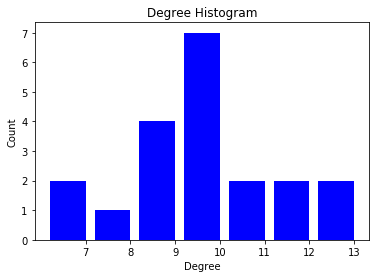

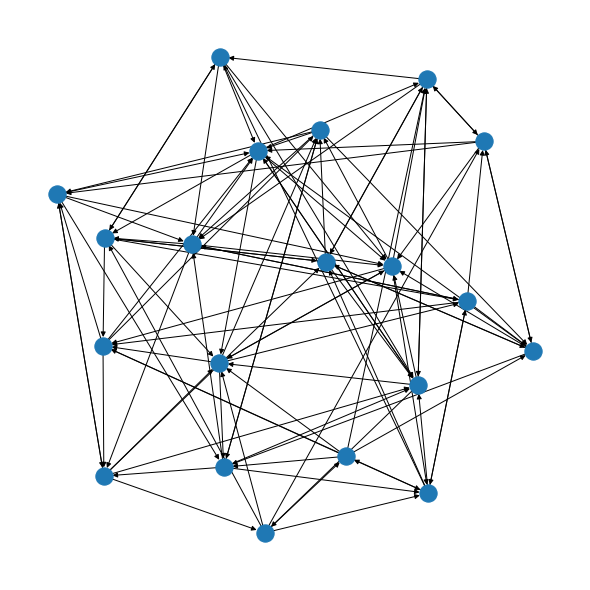

In [4]:
G1 = construct_graph(G, membership)

show_deg_dist(G1)

pos = nx.spring_layout(G1)
plt.figure(3,figsize=(8,8)) 
nx.draw(G1,pos)
plt.show()

In [5]:

from twisted.internet import reactor
from twisted.internet.threads import deferToThread
from twisted.internet.defer import DeferredList
from twisted.internet.threads import blockingCallFromThread

def inThread(defs):
    try:
        result = blockingCallFromThread(reactor, DeferredList, defs) 
    except Exception as exc:
        print(exc)
    else:
        #print (result)
        pass
    reactor.callFromThread(reactor.stop)

                
K = 10
t1 = time.time()
defs = []

new_set = []
for i in range(1000):
    # add new honest peer
    p = randomString()
    peer_mapping[p] = 1
    G.add_node(p)
    new_set.append(p)
        
# Init Brahms for initial peers 
for p in new_set:
    membership[p] = BrahmsMembers(p, 10, 20, 0.4, 0.4, 0.2)
    membership[p].bootstrap(G)
    
for r in range(K):    
    for p in G.nodes():
        defs.append(deferToThread(membership[p].run_round,))
    
reactor.callInThread(inThread, defs)
reactor.run()
print(time.time()-t1)



25.64163613319397


In [9]:
G1.nodes()

NodeView(('fntomoguar', 'uipnlofyva', 'yttgkvhsqg', 'dsupstgpyt', 'wbnjworqef', 'mmjgzgowcy', 'diwangosan', 'lqslszljmr', 'gyccovnxjm', 'tjihaztimw', 'davehpxwbv', 'zsodbbiuno', 'bwftaznokk', 'ohdahirrhk', 'uiekmyjcgx', 'rutvwgqicy', 'ijgiddvfdj', 'rpnbzfbgbe', 'xdtzhmuvmg', 'enwcvmbdna', 'hmjhwexrqb', 'hctxjkfqpu', 'xikgbnwbcy', 'ugeiqbvoit', 'hqnszgmsbh', 'wcueaorpni', 'nnmufhpiwl', 'aztcgnvlat', 'nidsznkdqc', 'gekupoqcnm', 'zbnmqwmsxx', 'taqcflhkhq', 'evdvjcmiaw', 'ynkzapfeaj', 'eputdcrlcp', 'ekzlawnzan', 'ajkghzkmgk', 'tppdiqrkvf', 'lgphvbssbz', 'bgxcnigzkw', 'phtkjnqnam', 'zqvxqjojho', 'wxgkdidamo', 'cjdqdpbsvn', 'rbrfkbtuyk', 'lzjlcoebql', 'dczauplizt', 'gwdznmqtpy', 'dvybhnqfvq', 'ychvtgxthw', 'lpwmrzxniq', 'mwtymtgzzv', 'lwutunntox', 'xyvzobyjgm', 'nihcrgkjsj', 'jjhpklmvzx', 'azabgrauhl', 'jwnqmdnwpa', 'bmugbqeefp', 'zqphlhswos', 'lidlpmpinl', 'jpbrtrsntu', 'ctoessvdcf', 'lprhiizayz', 'wwmacxolrf', 'nkhktzxyfk', 'xbhhoyjedh', 'cahhchujwm', 'chkapemkgg', 'kwshxakohv', 'qcfmceerp

<Figure size 576x576 with 0 Axes>

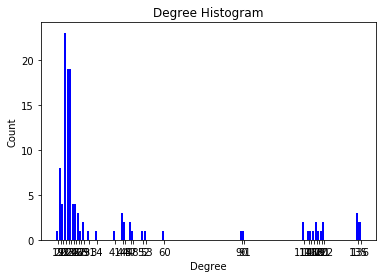

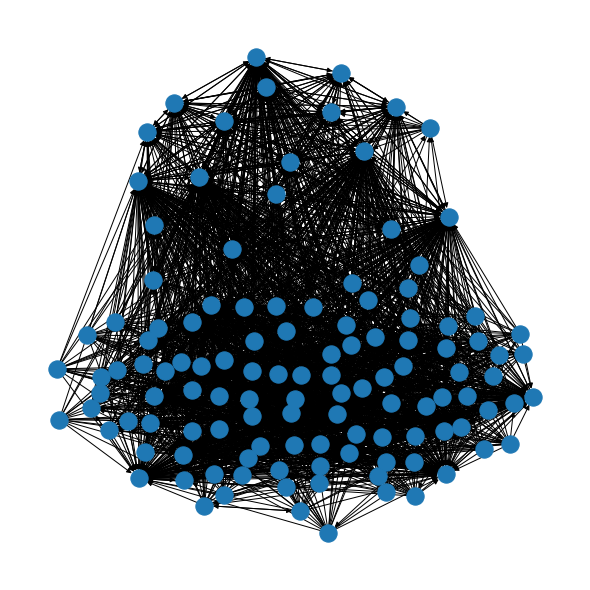

In [6]:
G1 = construct_graph(G, membership)

show_deg_dist(G1)

#pos = nx.spring_layout(G1)
#plt.figure(3,figsize=(8,8)) 
#nx.draw(G1,pos)
#plt.show()

In [12]:
Gp = G1.to_undirected()

In [15]:
degree_sequence = sorted([d for n, d in Gp.degree()], reverse=True)  # degree sequence
print(degree_sequence)

[121, 121, 121, 121, 121, 109, 109, 108, 107, 107, 106, 105, 105, 104, 102, 101, 81, 80, 52, 46, 41, 37, 34, 34, 33, 32, 31, 30, 30, 29, 28, 28, 27, 27, 27, 26, 26, 26, 26, 26, 26, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 20, 19]


In [7]:
G1.degree()

DiDegreeView({'ejzbxzwggo': 24, 'ogoczhduta': 43, 'psocbmfjdv': 132, 'oufptgokdf': 46, 'jqcbylxtwv': 19, 'ckttijfzqk': 16, 'vahmwjpces': 21, 'slsxatvfwn': 47, 'pdsizlfkzh': 24, 'igbjeapfre': 73, 'ocatperbqo': 132, 'jqzhykhgqq': 58, 'jpxedewejh': 21, 'thermitrxs': 132, 'htnrpanyxa': 23, 'qsfrprdrqu': 53, 'jjtavflrvs': 44, 'njcbvvkpge': 27, 'bokkqnpblq': 133, 'kesgldjkeu': 47, 'xzafnvdfsz': 24, 'htgqcojxxb': 24, 'itfjwznnjo': 24, 'thzjxcaqsg': 22, 'getwhxeyln': 25, 'tgzmmgkvfy': 24, 'lqpkauncwh': 22, 'zmpenyuplx': 115, 'ywetmzqbhe': 23, 'ealcffvcet': 25, 'qckvllfted': 23, 'gmxggfrkjz': 25, 'ooppleqgfm': 26, 'assbvwxvlo': 108, 'tvdquqruer': 23, 'lotififwvl': 23, 'heddufcmyj': 24, 'yueuhnxruz': 23, 'uiilebvdmf': 22, 'tjhvxznxhb': 23, 'qnlfyxobfq': 23, 'ukvwhiquxj': 26, 'wvlcyprhcc': 24, 'jadweovosx': 22, 'krobyfouds': 119, 'ukgaeczgfs': 23, 'tfozggmzou': 31, 'tqhzirfoln': 30, 'rfelwoxkrp': 23, 'zkewydwiro': 24, 'oiiapbipja': 25, 'yorqqstrin': 117, 'esfzjwmzfv': 97, 'phfdtqragb': 25, 'tvvss